# Tutorial to use Dynamic Expectation-Maximization algorithms for Mixed-type Data (DEM-MD) <a class="tocSkip"></a>

This notebook contains several use cases demonstrating **estimation of mixture models on mixed-type data.** 

We present **three** different algorithms, allowing to **estimate mixture models with variables distributed by respectively Gaussian, Student or Shifted Asymmetric Laplace distributions.** 
In addition, variables following discrete distributions can be present in the datasets, and our algorithms can **jointly estimate all distributions' parameters.** 
These algorithms are also **dynamically estimating the number of classes** of mixture models, so do not rely on posterior model selections.

This notebook is associated with the paper *[Dynamic Expectation-Maximization algorithms for Mixed-type Data](https://hal.science/hal-04510689)*.

This notebook is divided into the four following parts:
1. [Models and algorithms](#first-part)
2. [Toy datasets](#second-part)
3. [Model estimation](#third-part)
4. [Estimation errors](#fourth-part)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os;import sys
sys.path.append('./') 
from utils.sampling import simulation_mixed_data
# Fix random seed
import random
random.seed(1)

## Models and algorithms <a id="first-part"></a>

In this notebook, we aim at estimating mixture models on datasets composed of mixed-type variables, which means that variables are not coming only from continuous distributions (as the most known the Gaussian one) but also from discrete distributions. 


### Definitions
An observation of mixed variables is given by $\bf{x}=(\bf{x}^{1},\dots,\bf{x}^{g},{x}^{g+1},\dots,{x}^{g+D}) \in \mathbb{R}^G \times \mathcal{X}$. 
The $g$ first variables are continuous variables defined on $\mathbb{R}^G$. 
The vector of these continuous variables is denoted $\bf{x}^c$. 
The vector of the $D$ discretly distributed variables (integer, nominal, binary, \dots) is defined on $\mathcal{X}$ and denoted $\bf{x}^D$ with $x^d$ being the $d th$ discretly distributed variable. 
<!-- If $x^d$ is a nominal variable with $m_d$ modalities, then it uses a numeric coding $\{1,\dots,m_d\}$. -->

An observation $\bf{x}$ is a realization of a random variable $\mathbf{X}$ distributed according to a mixture model of $K$ classes, whose pdf is written as


\begin{equation*}
    p(\bf{x};\Theta)=\sum \limits_{k=1}^{K} \pi_{k} p(\bf{x};\theta_k) = \sum_{k=1}^{K} \pi_k p_{g}(\bf{x}^c;\theta^c_k) \prod_{d=1}^{D}p_{X^d}(x^d;\theta_k^d)\,,
\end{equation*}

with ${\Theta}=(\bf{\pi},\bf{\xi}_1,\dots,\bf{\xi}_K)$ the whole parameters set, and $\bf{\xi}_k$ contains $\left({\theta}_k^c,{\theta}_k^1,\dots,{\theta}_k^D\right)$, parameters of continuous and discrete distributions of each component $k \in \{1,\dots,K\}$.

**Reminder on some points**:
- **Only one multivariate continuous distribution** can be considered in our mixture models. For example we cannot mix here variables following a Gaussian distribution and variables following a Student distribution.
- **Any** number of variables following discrete distributions can be considered, and with possibly **different distributions**.

### Available distributions

As we propose algorithms to estimate mixture models on mixed-type data, we give here the list of available distributions in our code.

The discrete distributions are **Bernoulli** distribution, **Multinomial** distribution and **Poisson** distribution.

This table gives the possible multivariate continuous distributions, and their parameters:

| Parameter | Description | In which distribution|
|:-:|:-:|:-:| 
|$ \pi$ | proportions of the mixture model | Gaussian, Student SAL|
|$\mu$ | location parameters  |  Gaussian, Student, SAL | 
| ${\Sigma}$ | scale parameters |Gaussian, Student, SAL | 
| ${\nu}$ | degrees of freedom | Student| 
| $\alpha$ | skewness parameters | Shifted Asymmetric Laplace (SAL)|

We refer the reader to our article *[Dynamic Expectation-Maximization algorithms for Mixed-type Data](https://hal.science/hal-04510689)* for more details on the models, and references on the distributions.

### Description of the Algorithms 

The main part of this work and this notebook is to provide algorithms to **estimate the parameters of mixture models** defined as above, for different continuous and discrete distributions.\
We propose **Dynamical Expectation-Maximization algorithms for Mixed-Type Data (DEM-MD)**.\
DEM-MD algorithms **jointly** estimate **mixture model parameters** and **$K$ the number of components**.

Three different classes are available, depending on the considered continuous distribution. With each of these classes, discrete distributions are included, to be able to estimate mixture models with continuous and discrete distributions.

In the next part we create the toy datasets used later to demonstrate model estimations with our algorithms.

## Toy datasets <a  id="second-part"></a>

In this notebook we simulate 3 complete datasets with mixed-type data.\
Each dataset will be composed of `n` points, `K` components per mixture model, `c` variables following **continuous** distributions, and `d` variables following **discrete** distributions.

Here the function `simulation_mixed_data` is used to sample data from mixture models, but the user can consider any other way to simulate data. \
Later we will provide requirements on data formatting for estimation process.

### Simulation of a Gaussian dataset

The first dataset is sampled from a mixture of `K=n_components=2` components, `c=n_dim=2` **Gaussian** variables, and `d=3` variables with $1$ Bernoulli variable, $1$ Poisson variable and $1$ Multinomial variable.  

In [3]:
n_components = 2 # or K, the number of components
n_dim = 2 # or c, the number of continuous dimensions
n_samples = 400 # or n, the size of the dataset

### Parameters for Gaussian distributions
proportions = np.array([1./4., 3./4.])
locations = np.array([[-6,1],[4,2]])
scales = np.array([[[1,0],[0,3]],[[2,0.5],[0.5,4]]])

### Parameters for discrete distributions
Multinomial0 = np.array([[0.8,0.1,0.1],[0.1,0.7,0.2]])
Poisson1 = np.array([30,80])
Bernoulli2 = np.array([0.2,0.7])

In [4]:
args = ["proportions", "locations", "scales"]
dict_cont_gaussian = {i:eval(i) for i in args} 

args = ["Multinomial0", "Poisson1", "Bernoulli2"]
dict_discr_gaussian = {i:eval(i) for i in args} 

In [5]:
data_gaussian, true_labels_gaussian = simulation_mixed_data('Gaussian',["Multinomial",'Poisson', 'Bernoulli'],dict_cont_gaussian,dict_discr_gaussian,n_samples)

With `simulation_mixed_data` from `utils.simulations_distrib`, we obtain here a dataset of size `(400,5)` with the two first columns corresponding to the continuous distribution, and the last three to the discrete distributions.

#### Visualize

We can plot the first two columns of the dataset, and color with any of the other variables.

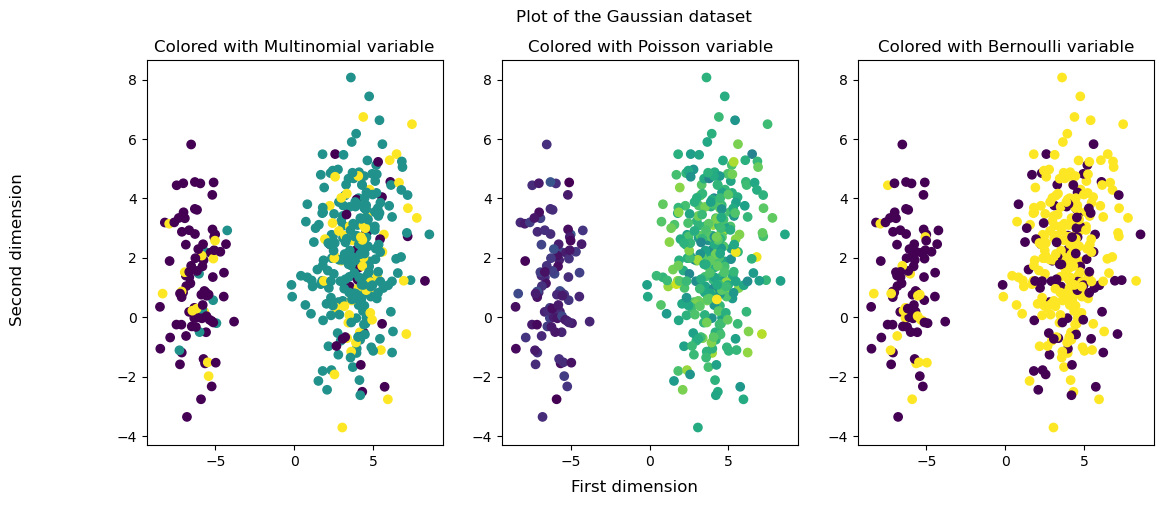

In [6]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
axes[0].scatter(*data_gaussian[:,:2].T,c=data_gaussian[:,2])
axes[0].set_title('Colored with Multinomial variable')
axes[1].scatter(*data_gaussian[:,:2].T,c=data_gaussian[:,3])
axes[1].set_title('Colored with Poisson variable')
axes[2].scatter(*data_gaussian[:,:2].T,c=data_gaussian[:,4])
axes[2].set_title('Colored with Bernoulli variable')
plt.suptitle('Plot of the Gaussian dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

### Simulation of a Student dataset

This second dataset is sampled from a mixture of `K=n_components=3` components, `c=n_dim=2` **Student** variables, 
and `d=3` variables with $1$ Bernoulli variable, $1$ Poisson variable and $1$ Multinomial variable.  

In [7]:
n_components = 3 # or K, the number of components
n_dim = 2 # or c, the number of continuous dimensions
n_samples = 600 # or n, the size of the dataset

### Parameters for Student distributions
proportions = np.array([1./4., 1./4., 1./2.])
locations = np.array([[-6,1],[4,5],[3,-3]])
scales = np.array([[[1,0],[0,3]],[[2,0.5],[0.5,4]],[[1,0.5],[0.5,1]]])
dofs = np.array([3,6,4])

### Parameters for discrete distributions
Poisson0 = np.array([35,80,40])
Multinomial1 = np.array([[0.8,0.1,0.1],[0.1,0.7,0.2],[0.1,0.4,0.5]])
Bernoulli2 = np.array([0.2,0.4,0.3])

In [8]:
args = ["proportions", "locations", "scales", 'dofs']
dict_cont_student = {i:eval(i) for i in args} 

args = ["Poisson0", "Multinomial1", "Bernoulli2"]
dict_discr_student = {i:eval(i) for i in args} 

In [9]:
data_student, true_labels_student = simulation_mixed_data('Student',['Poisson','Multinomial','Bernoulli'],dict_cont_student,dict_discr_student,n_samples)

#### Visualize

We can plot the first two columns of the dataset, and color with any of the other variables.

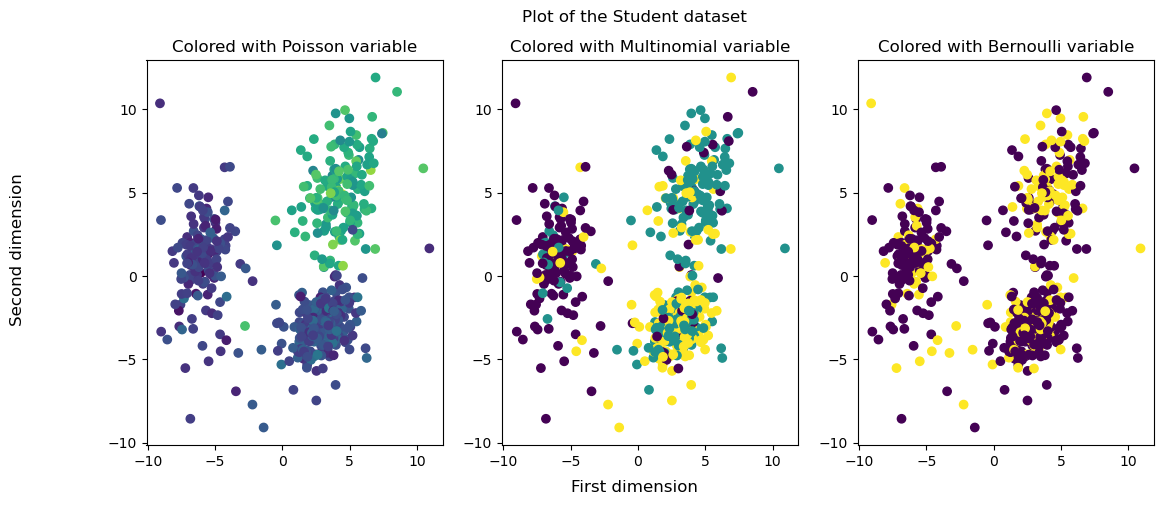

In [10]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
axes[0].scatter(*data_student[:,:2].T,c=data_student[:,2])
axes[0].set_title('Colored with Poisson variable')
axes[1].scatter(*data_student[:,:2].T,c=data_student[:,3])
axes[1].set_title('Colored with Multinomial variable')
axes[2].scatter(*data_student[:,:2].T,c=data_student[:,4])
axes[2].set_title('Colored with Bernoulli variable')
plt.suptitle('Plot of the Student dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

### Simulation of a SAL dataset

The third dataset is sampled from a mixture of `K=n_components=2` components, `c=n_dim=2` **SAL** variables, and `d=3` variables with $1$ Bernoulli variable, $1$ Poisson variable and $1$ Multinomial variable.  

In [11]:
n_components = 2
n_dim = 2
n_samples = 400

### Parameters for SAL distributions
proportions = np.array([1./4., 3./4.])
locations = np.array([[-6,1],[4,2]])
scales = np.array([[[1,0],[0,3]],[[2,0.5],[0.5,4]]])
alphas = np.array([[-3,2],[1,4]])

### Parameters for discrete distributions
Bernoulli0 = np.array([0.65,0.35])
Multinomial1 = np.array([[0.2,0.4,0.2],[0.3,0.1,0.6]])
Poisson2 = np.array([100,22])

In [12]:
args = ["proportions", "locations", "scales", "alphas"]
dict_cont_sal = {i:eval(i) for i in args} 

args = ["Bernoulli0", "Multinomial1", "Poisson2"]
dict_discr_sal = {i:eval(i) for i in args} 

In [13]:
data_sal, true_labels_sal = simulation_mixed_data('SAL',["Bernoulli",'Multinomial', 'Poisson'],dict_cont_sal,dict_discr_sal,n_samples)

#### Visualize

We can plot the first two columns of the dataset, and color with any of the other variables.

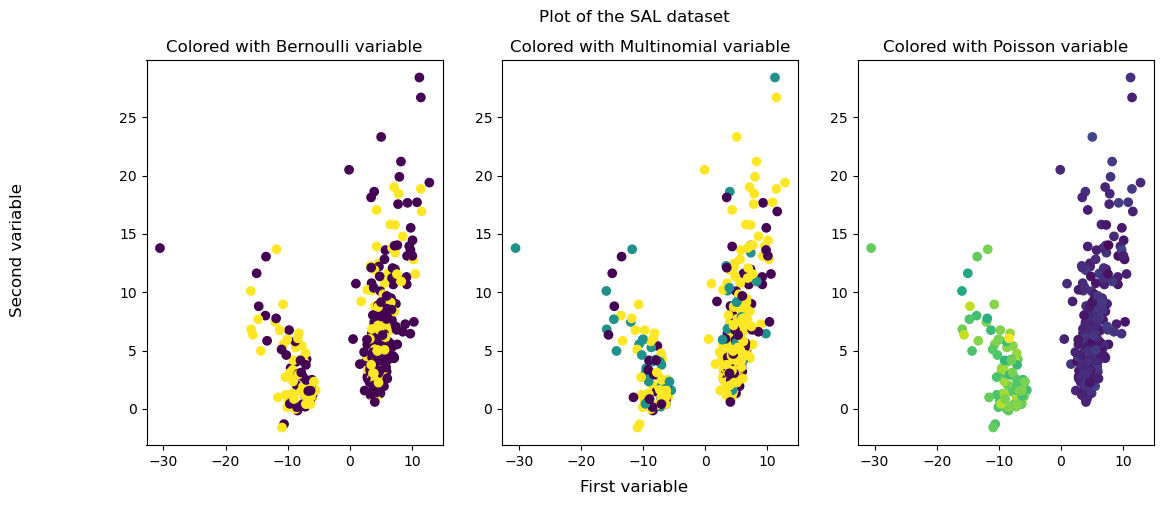

In [14]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
axes[0].scatter(*data_sal[:,:2].T,c=data_sal[:,2])
axes[0].set_title('Colored with Bernoulli variable')
axes[1].scatter(*data_sal[:,:2].T,c=data_sal[:,3])
axes[1].set_title('Colored with Multinomial variable')
axes[2].scatter(*data_sal[:,:2].T,c=data_sal[:,4])
axes[2].set_title('Colored with Poisson variable')
plt.suptitle('Plot of the SAL dataset')
fig.supxlabel('First variable')
fig.supylabel('Second variable')
plt.show()

## Model Estimation <a  id="third-part"></a>

### Description

In this work, we use Dynamical EM algorithms for Mixed-type Data (DEM-MD) to **jointly** estimate mixture models parameters and the number of components **K**.

So we provide three classes, `GaussianDEMMD`, `StudentDEMMD` and `SALDEMMD` to estimate mixture models with respectively `Gaussian`, `Student` or `SAL` distributions.\
In addition, the datasets can include zero, one or many variables following discrete distributions. The implemented discrete distributions are `Bernoulli`, `Multinomial` and `Poisson`.

#### Common functions

Each of the above classes presents the following functions:
- `fit_predict(x)`: estimates model parameters and K using x and predicts the labels for x. 
- `fit(x)`: estimate model parameters and K using x.
- `score_samples(x)`: compute the log-likelihood of each sample of x.
- `score(x)`: compute the per-sample average log-likelihood of x.
- `predict(x)`: predicts the labels for x.
- `bic(x)`, `icl(x)`, `nec(x)`: compute respectively Bayesian Information criterion, Integrative Complete Likelihood and Negative Entropy Criterion, for the current model on the input x.

### Estimation of Gaussian mixture models

Firstly the user has to create an object corresponding to the mixture model he wants to estimate.\
For example here, to estimate a Gaussian mixture model, a `GaussianDEMMD`object is created.\
The initialization parameters are:

- `eps`: the convergence threshold. The DEM-MD will stop when the stopping criterion is below this threshold. Default = 1e-6
- `gamma`: non-negative regularization added to the diagonal of scale matrix. Default = 1e-4
- `type_discrete_features`: list of considered discrete distributions, **in the order** they appear in the dataset. Default = None (for no discrete distribution)
- `index_discrete_features`: list of arrays, **one array per discrete distribution**. Each array includes index (or indexes) of corresponding variable. Default = [np.array([2])] (ignored when no declared discrete features in `type_discrete_features`)
- `is_dummy`: True if a multinomial variable is provided as dummy variables. Default = False

In [15]:
from DEM_MD_gaussian import GaussianDEMMD 

#### With only continuous features

In [16]:
cont_var = np.array([0,1])
data_cont = data_gaussian[:,cont_var]
print(data_cont.shape)

(400, 2)


Without any categorical feature, the dataset is only composed of continuous features.\
In this case `data_cont` is an  array of shape `(n_sample,c)`, here `(400,2)`.

In [17]:
GDEM1 = GaussianDEMMD()
labels_gaussian_1 = GDEM1.fit_predict(data_cont)

In [18]:
print(f"Log-likelihood of DEM-MD on full_data = {round(GDEM1.score(data_cont),3)}"+f" , with K = {GDEM1.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -4.414 , with K = 2 components estimated.


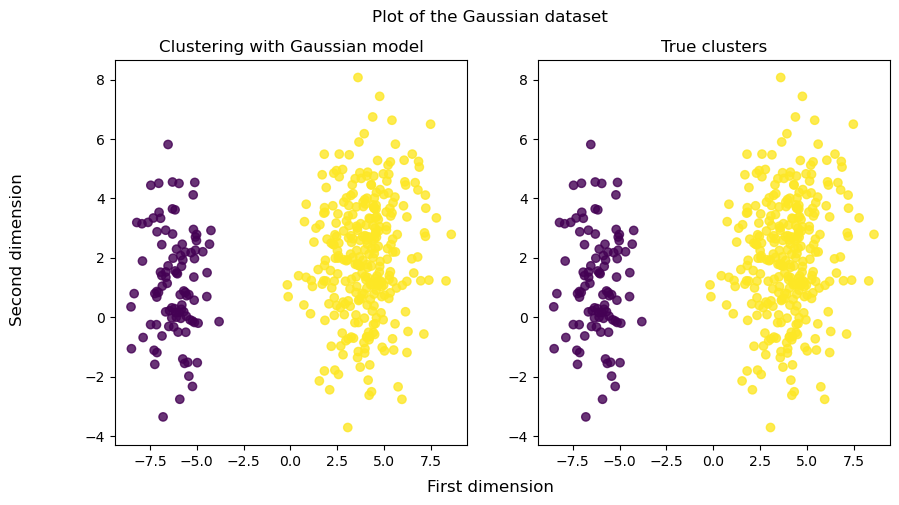

In [19]:
# display predicted scores by the model as a contour plot
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(*data_cont[:,:2].T,c=labels_gaussian_1,alpha=0.8)
axes[0].set_title('Clustering with Gaussian model')
axes[1].scatter(*data_cont[:,:2].T,c=true_labels_gaussian,alpha=0.8)
axes[1].set_title('True clusters')
plt.suptitle('Plot of the Gaussian dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

#### With one categorical feature

If you have variables following a discrete distribution, you should provide additional informations when creating a mixture model object.

Here we consider the Student dataset, with the two first features following a two-dimensional Student distribution, and one variable following a Multinomial distribution.\
In the Gaussian complete dataset sampled in first part, the Multinomial variable is indexed at 3rd position, with `index_discrfeat`.\
We take the subset with this Multinomial variable and the Gaussian variables.

In [20]:
index_discrfeat = np.array([2])
data_cat = np.array(data_gaussian[:,index_discrfeat]) 

In [21]:
full_data = np.concatenate([data_cont,data_cat],axis=1)

In this case `full_data` is an array of shape `(400,3)`.

We have to provide information on the discrete distributions we consider with `type_feat_cat` variable.\
And `index_discrfeat_fit` includes the array giving the Multinomial featur eposition in the formatted dataset.

In [22]:
index_discrfeat_fit = [np.array([2])]
type_feat_cat = ['Multinomial']

In [23]:
GDEM2 = GaussianDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_gaussian_2 = GDEM2.fit_predict(full_data)

In [24]:
print(f"Log-likelihood of DEM-MD on full_data = {round(GDEM2.score(full_data),3)}"+f" , with K = {GDEM2.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -5.135 , with K = 2 components estimated.


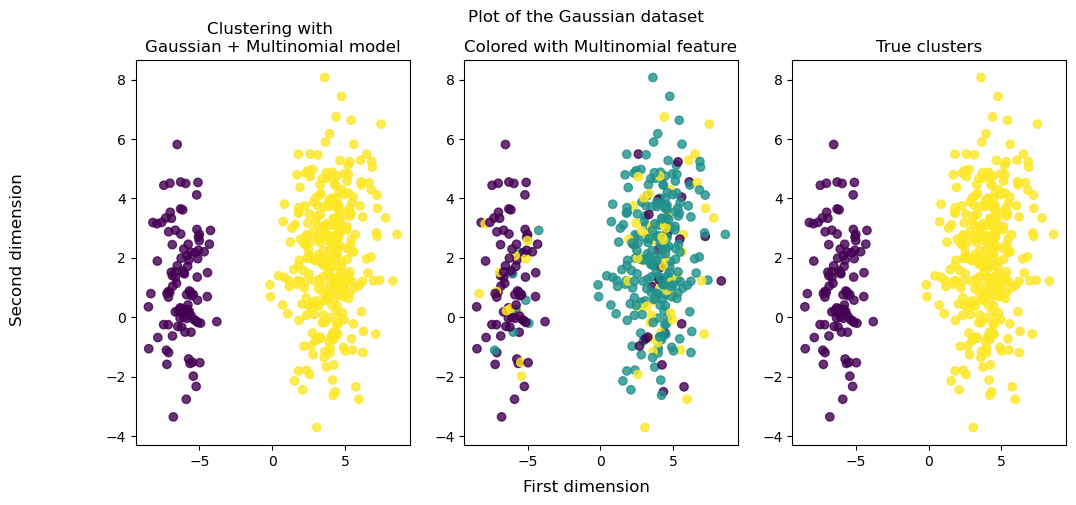

In [25]:
# display predicted scores by the model as a contour plot
fig,axes = plt.subplots(1,3,figsize=(12,5))
axes[0].scatter(*full_data[:,:2].T,c=labels_gaussian_2,alpha=0.8)
axes[0].set_title('Clustering with \nGaussian + Multinomial model')
axes[1].scatter(*full_data[:,:2].T,c=full_data[:,2],alpha=0.8)
axes[1].set_title('Colored with Multinomial feature')
axes[2].scatter(*full_data[:,:2].T,c=true_labels_gaussian,alpha=0.8)
axes[2].set_title('True clusters')
plt.suptitle('Plot of the Gaussian dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

#### When a Multinomial feature is given as a dummy variable

In our mixture classes a Multinomial feature can be given as a dummy variable. In this case and for this dataset, the Multinomial feature corresponds to an array of shape `(n_samples,M)` with `M` the number of modalities of the Multinomial feature.
Here the Multinomial feature in the Gaussian dataset has `M=3` modalities.  For the demonstration we will tranform the feature in the dataset. 

In [26]:
from pandas import get_dummies
data_multi_dummy = get_dummies(data_gaussian[:,2])
full_data = np.concatenate([data_cont,data_multi_dummy],axis=1)

So here we have full_data of shape `(400,5)`. The index array `index_discrfeat_fit` for the Multinomial feature is now composed of several values corresponding to the dummy columns.\
`type_feat_cat` does not changed.

In [27]:
index_discrfeat_fit = [np.array([2,3,4])]
type_feat_cat = ['Multinomial']

The difference in the declaration below is `is_dummy=True`.\
The estimation results are the same as just the preprocessing step changed.

In [28]:
GDEM2 = GaussianDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit,is_dummy=True)
labels_gaussian_2_dummy = GDEM2.fit_predict(full_data)

In [29]:
print(f"Log-likelihood of DEM-MD on full_data = {round(GDEM2.score(full_data),3)}"+f" , with K = {GDEM2.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -5.135 , with K = 2 components estimated.


In [30]:
(labels_gaussian_2==labels_gaussian_2_dummy).all()

True

#### With several categorical features

Here we consider several categorical features, following respectively a `Multinomial` distribution, a `Poisson` distribution and a `Bernoulli` distribution.

In [31]:
index_discrfeat = np.array([2,3,4])
data_cat = np.array(data_gaussian[:,index_discrfeat]) 

full_data = np.concatenate([data_cont,data_cat],axis=1)

We have to provide information on the discrete distributions we consider with `type_feat_cat` variable.\
`index_discrfeat_fit` is a `list` including one array per categorical feature. Each array gives the index of the corresponding feature in the dataset provided for estimation.

In [32]:
index_discrfeat_fit = [np.array([2]),np.array([3]),np.array([4])]
type_feat_cat = ['Multinomial','Poisson','Bernoulli']

In [33]:
GDEM3 = GaussianDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_gaussian_3 = GDEM3.fit_predict(full_data)

In [34]:
print(f"Log-likelihood of DEM-MD on full_data = {round(GDEM3.score(full_data),3)}"+f" , with K = {GDEM3.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -9.188 , with K = 2 components estimated.


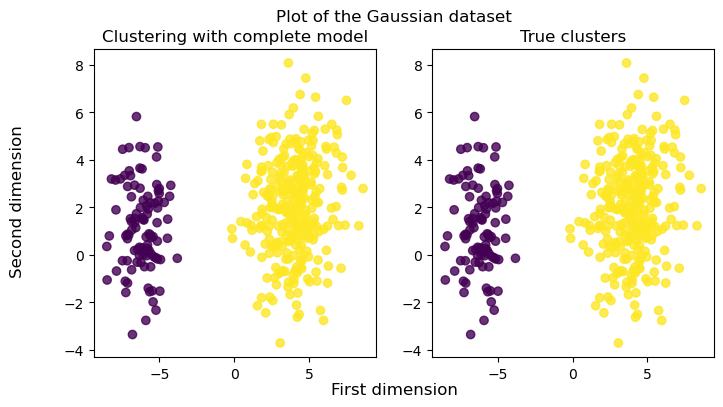

In [35]:
# display predicted scores by the model as a contour plot
fig,axes = plt.subplots(1,2,figsize=(8,4))
axes[0].scatter(*full_data[:,:2].T,c=labels_gaussian_3,alpha=0.8)
axes[0].set_title('Clustering with complete model')
axes[1].scatter(*full_data[:,:2].T,c=true_labels_gaussian,alpha=0.8)
axes[1].set_title('True clusters')
plt.suptitle('Plot of the Gaussian dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

#### When a Multinomial feature is given as a dummy variable

In our mixture classes a Multinomial feature can be given as a dummy variable. In this case and for this dataset, the Multinomial feature corresponds to an array of shape `(n_samples,M)` with `M` the number of modalities of the Multinomial feature.
Here the Multinomial feature in the Gaussian dataset has `M=3` modalities.  For the demonstration we will tranform the feature in the dataset. 

In [36]:
data_cat = np.array(data_gaussian[:,3:]) 
data_multi_dummy = get_dummies(data_gaussian[:,2])
full_data = np.concatenate([data_cont,data_multi_dummy,data_cat],axis=1)

So here we have full_data of shape `(400,7)`. The index array `index_discrfeat_fit` for the Multinomial feature is now composed of several values corresponding to the dummy columns.\
The other index arrays correspond to Poisson and Bernoulli features in the dataset `full_data`.\
The list `type_feat_cat` does not changed, as the features are in the same order.

In [37]:
index_discrfeat_fit = [np.array([2,3,4]),np.array([5]),np.array([6])]
type_feat_cat = ['Multinomial','Poisson','Bernoulli']

The difference in the declaration below is `is_dummy=True`.\
The estimation results are the same as just the preprocessing step changed.

In [38]:
GDEM3 = GaussianDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit,is_dummy=True)
labels_gaussian_3_dummy = GDEM3.fit_predict(full_data)

In [39]:
print(f"Log-likelihood of DEM-MD on full_data = {round(GDEM3.score(full_data),3)}"+f", with K = {GDEM3.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -9.188, with K = 2 components estimated.


### Estimation of Student mixture models

Firstly the user has to create an object corresponding to the mixture model he wants to estimate.\
For example here, to estimate a Student mixture model, a `StudentDEMMD`object is created.\
The initialization parameters are:

- `eps`: the convergence threshold. The DEM-MD will stop when the stopping criterion is below this threshold. Default = 1e-6
- `gamma`: non-negative regularization added to the diagonal of scale matrix. Default = 1e-4
- `type_discrete_features`: list of considered discrete distributions, **in the order** they appear in the dataset. Default = None (for no discrete distribution)
- `index_discrete_features`: list of arrays, **one array per discrete distribution**. Default = [np.array([2])] (ignored when no declared discrete features in `type_discrete_features`)
- `is_dummy`: True if a multinomial feature is provided as dummy variables in the dataset. Default = False

In [40]:
from DEM_MD_student import StudentDEMMD

#### With only continuous features

In [41]:
cont_var = np.array([0,1])
data_cont = data_student[:,cont_var]
print(data_cont.shape)

(600, 2)


Without any categorical feature, the dataset is only composed of continuous features.\
In this case `data_cont` is an array of shape `(n_sample,c)`, here `(600,2)`.

In [42]:
SDEM1 = StudentDEMMD()
labels_student_1 = SDEM1.fit_predict(data_cont)

In [43]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SDEM1.score(data_cont),3)}"+f" , with K = {SDEM1.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -4.596 , with K = 3 components estimated.


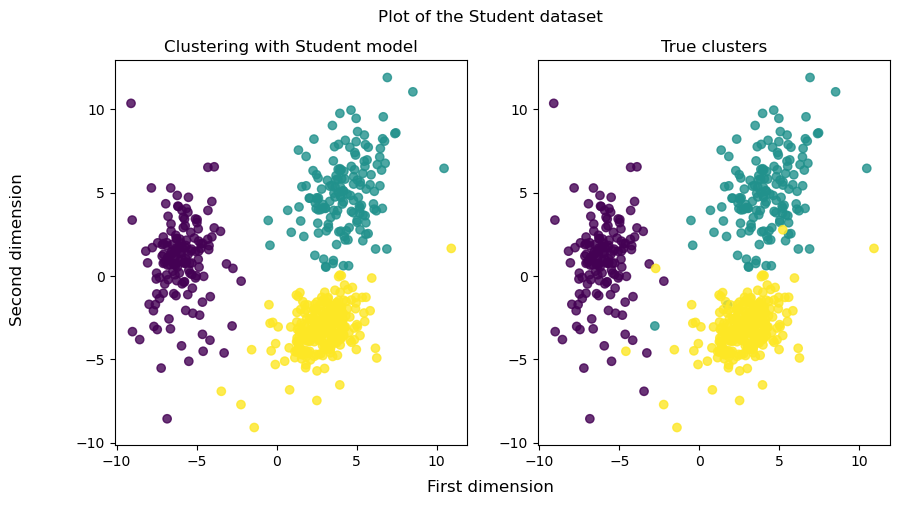

In [44]:
# display predicted scores by the model as a contour plot
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(*data_cont[:,:2].T,c=labels_student_1,alpha=0.8)
axes[0].set_title('Clustering with Student model')
axes[1].scatter(*data_cont[:,:2].T,c=true_labels_student,alpha=0.8)
axes[1].set_title('True clusters')
plt.suptitle('Plot of the Student dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

#### With one categorical feature

If you have variables following a discrete distribution, you should provide additional informations when creating a mixture model object.

##### Model  estimation with data including the Poisson featureax.set_visible(False)

Here we consider the Student dataset, with the two first features following a two-dimensional Student distribution, and one variable following a Poisson distribution.\
In the Student complete dataset sampled in first part, the Poisson variable is indexed at 3rd position, with `index_discrfeat`.\
We take a subset with this Poisson variable and the Student variables.

In [45]:
index_discrfeat = np.array([2])
data_cat = np.array(data_student[:,index_discrfeat]) 
full_data = np.concatenate([data_cont,data_cat],axis=1)

In this case `full_data` is an array of shape `(600,3)`.

We have to provide information on the discrete distributions we consider with `type_feat_cat` variable.\
And `index_catvar_fit` includes the array giving the Multinomial feature position in the formatted dataset.

In [46]:
index_discrfeat_fit = [np.array([2])]
type_feat_cat = ['Poisson']

In [47]:
SDEM2 = StudentDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_student_2 = SDEM2.fit_predict(full_data)

In [48]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SDEM2.score(full_data),3)}"+f" , with K = {SDEM2.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -7.976 , with K = 3 components estimated.


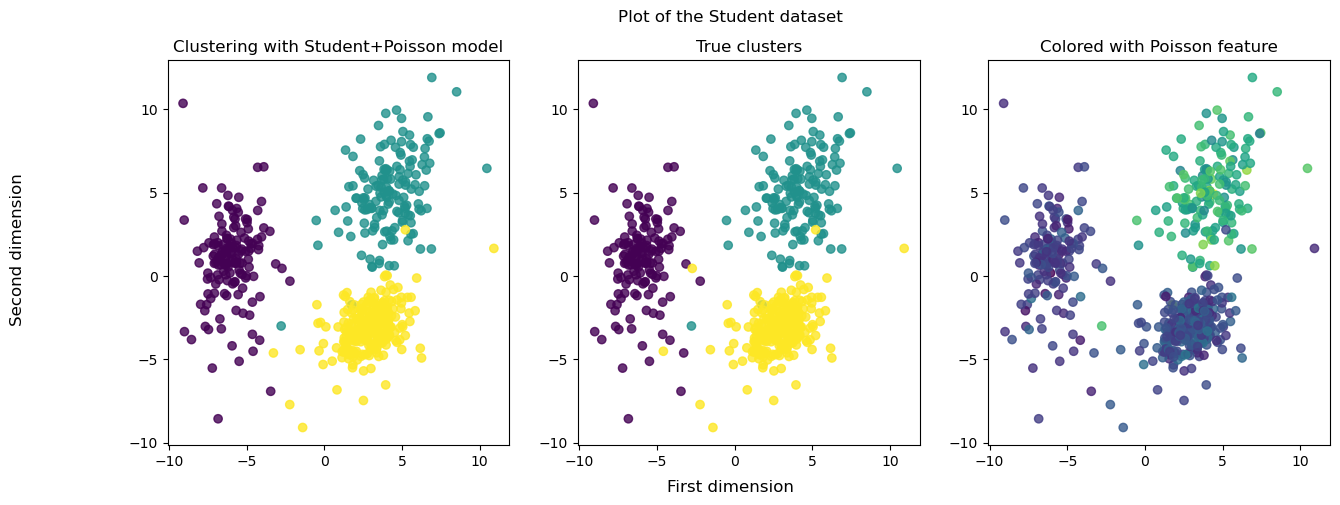

In [49]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].scatter(*full_data[:,:2].T,c=labels_student_2,alpha=0.8)
axes[0].set_title('Clustering with Student+Poisson model')
axes[1].scatter(*full_data[:,:2].T,c=true_labels_student,alpha=0.8)
axes[1].set_title('True clusters')
axes[2].scatter(*full_data[:,:2].T,c=full_data[:,2],alpha=0.8)
axes[2].set_title('Colored with Poisson feature')
plt.suptitle('Plot of the Student dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

##### Model  estimation with data including the Multinomial feature

Here we consider the Student dataset, with the two first features following a two-dimensional Student distribution, and one feature following a Multinomial distribution.\
We take a subset with this Multinomial feature and the Student features.\
**Goal**: the idea here is then to compare clustering with this model and the previous one, differing by the considered discrete feature.

In [50]:
index_discrfeat = np.array([3])
data_cat = np.array(data_student[:,index_discrfeat]) 
full_data = np.concatenate([data_cont,data_cat],axis=1)

In [51]:
index_discrfeat_fit = [np.array([2])]
type_feat_cat = ['Multinomial']

In [52]:
SDEM2_alt = StudentDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_student_2_alt = SDEM2_alt.fit_predict(full_data)

In [53]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SDEM2.score(full_data),3)}"+f" , with K = {SDEM2.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -37.662 , with K = 3 components estimated.


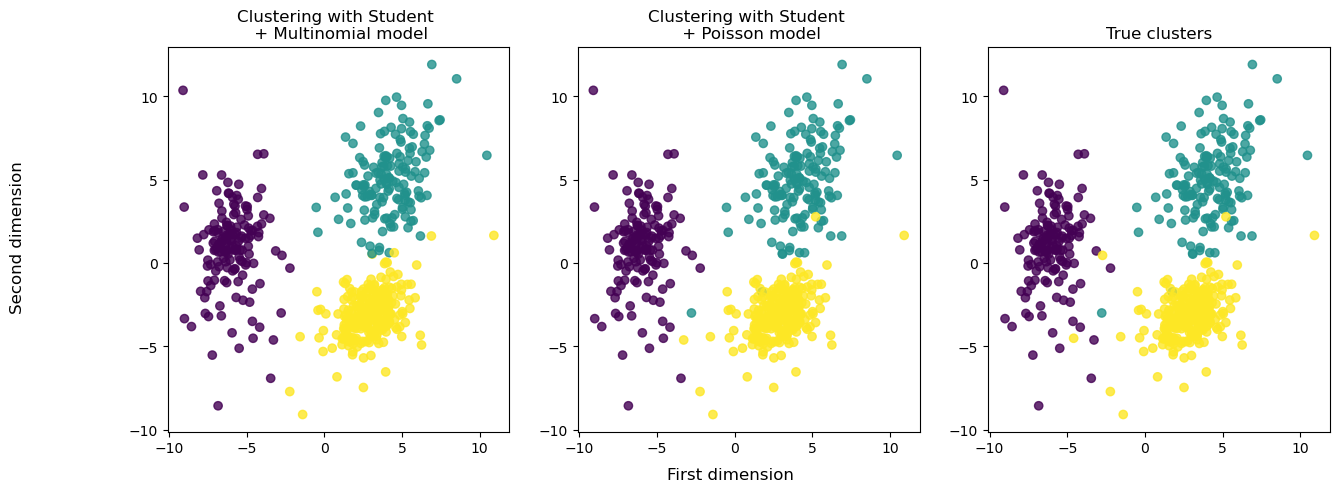

In [54]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].scatter(*full_data[:,:2].T,c=labels_student_2_alt,alpha=0.8)
axes[0].set_title('Clustering with Student \n + Multinomial model')
axes[1].scatter(*full_data[:,:2].T,c=labels_student_2,alpha=0.8)
axes[1].set_title('Clustering with Student \n + Poisson model')
axes[2].scatter(*full_data[:,:2].T,c=true_labels_student,alpha=0.8)
axes[2].set_title('True clusters')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

**Brief observation**: we see here that the Poisson feature drives more information on clusters than the Multinomial variable. Then it improves hard assignments if we compare two models with Student features and respectively Poisson or Multinomial features.

#### With several categorical features

Here we consider several categorical features, following respectively a `Poisson` distribution, a `Multinomial` distribution and a `Bernoulli` distribution.

In [55]:
index_discrfeat = np.array([2,3,4])
data_cat = np.array(data_student[:,index_discrfeat]) 

full_data = np.concatenate([data_cont,data_cat],axis=1)

We have to provide information on the discrete distributions we consider with `type_feat_cat` variable.\
 `index_discrfeat_fit` is a `list` including one array per categorical feature. Each array gives the index of the corresponding feature in the dataset provided for estimation.

In [56]:
index_discrfeat_fit = [np.array([2]),np.array([3]),np.array([4])]
type_feat_cat = ['Poisson','Multinomial','Bernoulli']

In [57]:
SDEM3 = StudentDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_student_3 = SDEM3.fit_predict(full_data)

In [58]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SDEM3.score(full_data),3)}"+f" , with K = {SDEM3.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -9.417 , with K = 3 components estimated.


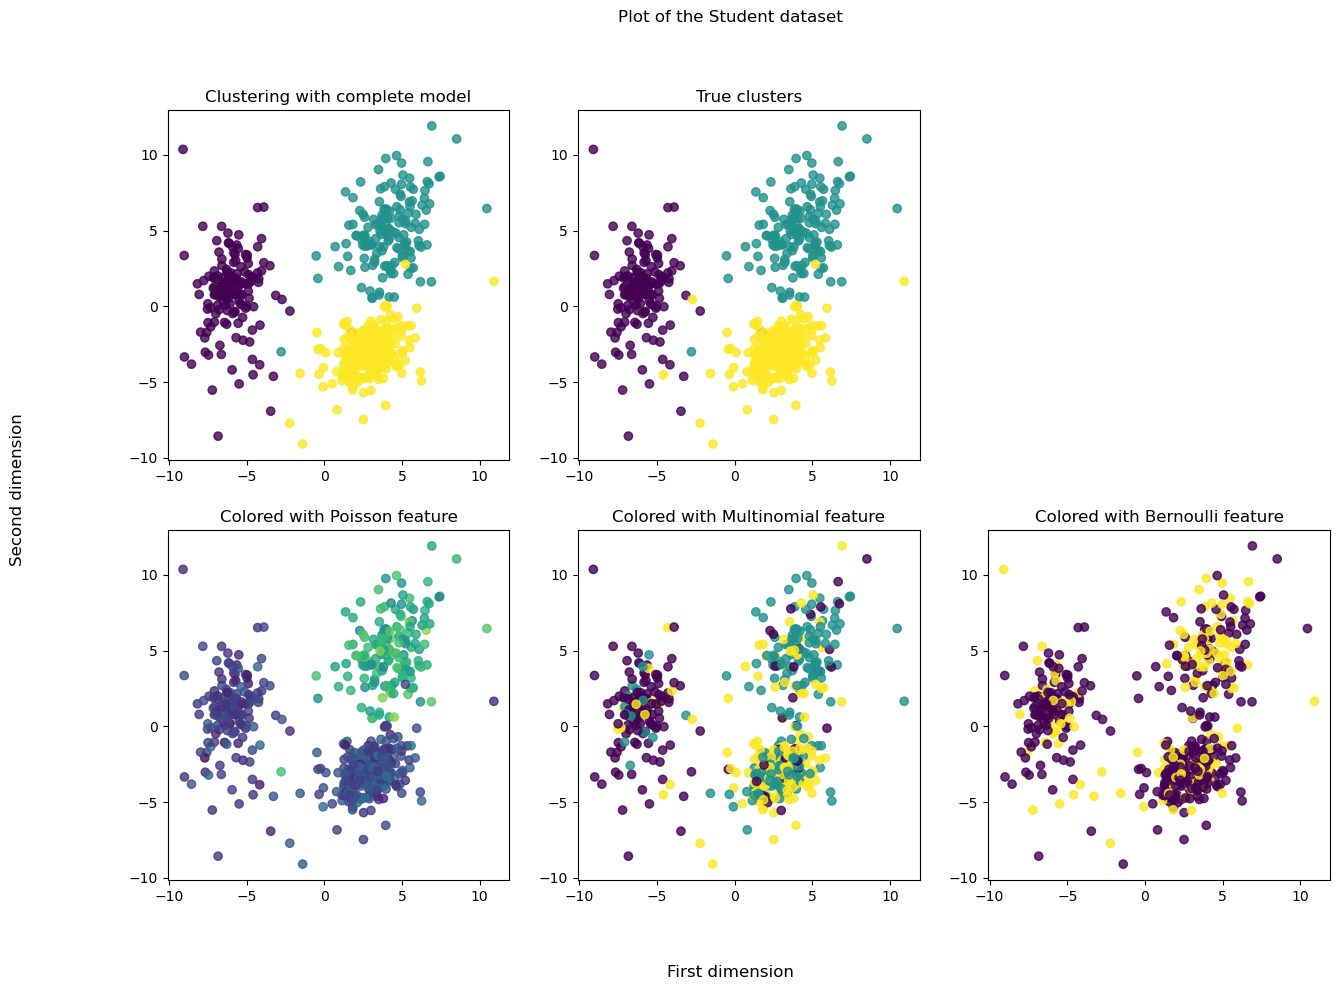

In [59]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
axes[0,0].scatter(*full_data[:,:2].T,c=labels_student_3,alpha=0.8)
axes[0,0].set_title('Clustering with complete model')
axes[0,1].scatter(*full_data[:,:2].T,c=true_labels_student,alpha=0.8)
axes[0,1].set_title('True clusters')
axes[0,2].set_visible(False)
axes[1,0].scatter(*full_data[:,:2].T,c=full_data[:,2],alpha=0.8)
axes[1,0].set_title('Colored with Poisson feature')
axes[1,1].scatter(*full_data[:,:2].T,c=full_data[:,3],alpha=0.8)
axes[1,1].set_title('Colored with Multinomial feature')
axes[1,2].scatter(*full_data[:,:2].T,c=full_data[:,4],alpha=0.8)
axes[1,2].set_title('Colored with Bernoulli feature')
plt.suptitle('Plot of the Student dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

### Estimations of Shifted Asymmetric Laplace mixture models

Firstly the user has to create an object corresponding to the mixture model he wants to estimate.\
For example here, to estimate a Shifted Asymmetric Laplace mixture model, a `SALDEMMD`object is created.\
The initialization parameters are:

- `eps`: the convergence threshold. The DEM-MD will stop when the stopping criterion is below this threshold. Default = 1e-4
- `gamma`: non-negative regularization added to the diagonal of scale matrix. Default = 1e-4
- `type_discrete_features`: list of considered discrete distributions, **in the order** they appear in the dataset. Default = None (for no discrete distribution)
- `index_discrete_features`: list of arrays, **one array per discrete distribution**. Default = [np.array([2])] (ignored when no declared discrete features in `type_discrete_features`)
- `is_dummy`: True if a multinomial variable is provided as dummy variables. Default = False
- `use_temperature`: use a temperature scheme on latent probabilities. Default = True
- `temp_b` and`temp_rb`: temperature scheme parameters. Default temp_b=1, temp_rb=3

In [60]:
from DEM_MD_sal import SALDEMMD

#### With only continuous features

In [61]:
cont_var = np.array([0,1])
data_cont = data_sal[:,cont_var]
print(data_cont.shape)

(400, 2)


Without any categorical feature, the dataset is only composed of continuous features.\
In this case `data_cont` is an array of shape `(n_sample,c)`, here `(400,2)`.

In [62]:
SALDEM1 = SALDEMMD()
labels_sal_1 = SALDEM1.fit_predict(data_cont,cov_comput='original')

/Users/solange/Documents/DEM_MD/DEM_MD_sal.py:337: RuntimeWarning: divide by zero encountered in log
  log_b = np.log(b[k, :])
/Users/solange/Documents/DEM_MD/DEM_MD_sal.py:49: RuntimeWarning: divide by zero encountered in log
  log_maha = np.log(mahala)


In [63]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SALDEM1.score(data_cont),3)}"+f" , with K = {SALDEM1.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -4.806 , with K = 4 components estimated.


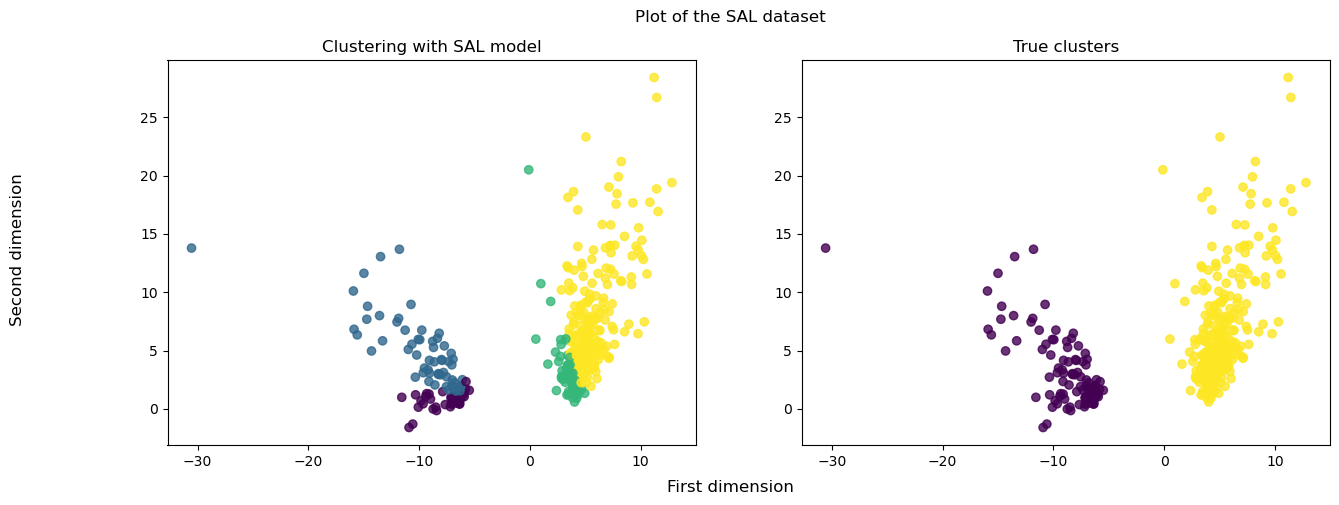

In [64]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].scatter(*data_cont[:,:2].T,c=labels_sal_1,alpha=0.8)
axes[0].set_title('Clustering with SAL model')
axes[1].scatter(*data_cont[:,:2].T,c=true_labels_sal,alpha=0.8)
axes[1].set_title('True clusters')
plt.suptitle('Plot of the SAL dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

#### With one categorical feature

If you have variables following a discrete distribution, you should provide additional informations when creating a mixture model object.

Here we consider the SAL dataset, with the two first features following a two-dimensional Student distribution, and one variable following a Bernoulli distribution.\
In the SAL complete dataset sampled in 3., position of the Bernoulli variable is given by `index_discrfeat`.\
We take a subset with this Bernoulli variable and the SAL variables.

In [65]:
index_discrfeat = np.array([2])
data_cat = np.array(data_sal[:,index_discrfeat])
data_cont = data_sal[:,cont_var]
full_data = np.concatenate([data_cont,data_cat],axis=1)

In this case `full_data` is an array of shape `(400,3)`.

We have to provide information on the discrete distributions we consider with `type_feat_cat` variable.\
And `index_discrfeat_fit` includes the array giving the Multinomial feature position in the formatted dataset.

In [66]:
index_discrfeat_fit = [np.array([2])]
type_feat_cat = ['Bernoulli']

In [67]:
SALDEM2 = SALDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_sal_2 = SALDEM2.fit_predict(full_data)

In [68]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SALDEM2.score(full_data),3)}"+f", with K = {SALDEM2.n_components} components estimated.")

Log-likelihood of DEM-MD on full_data = -5.519, with K = 2 components estimated.


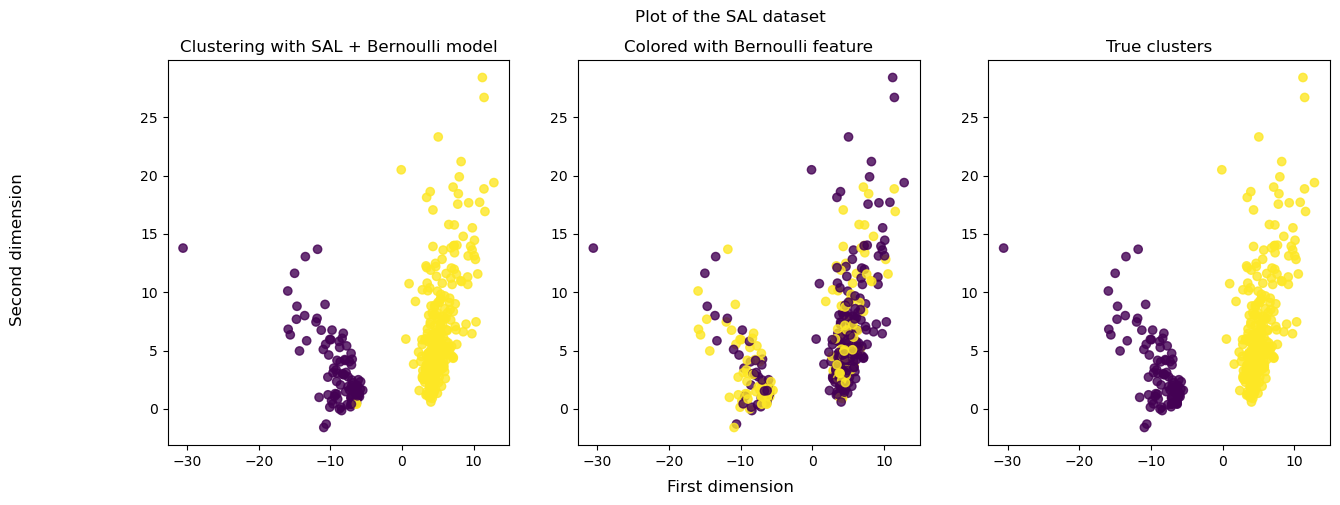

In [69]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].scatter(*full_data[:,:2].T,c=labels_sal_2,alpha=0.8)
axes[0].set_title('Clustering with SAL + Bernoulli model')
axes[1].scatter(*full_data[:,:2].T,c=full_data[:,2],alpha=0.8)
axes[1].set_title('Colored with Bernoulli feature')
axes[2].scatter(*full_data[:,:2].T,c=true_labels_sal,alpha=0.8)
axes[2].set_title('True clusters')
plt.suptitle('Plot of the SAL dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

#### With several categorical features

Here we consider several categorical features, following respectively a `Bernoulli` distribution, a `Multinomial` distribution and a `Poisson` distribution.

In [70]:
index_discrfeat = np.array([2,3,4])
data_cat = np.array(data_sal[:,index_discrfeat]) 
data_cont = data_sal[:,cont_var]
full_data = np.concatenate([data_cont,data_cat],axis=1)

We have to provide information on the discrete distributions we consider with `type_feat_cat` variable.\
 `index_discrfeat_fit` is a `list` including one array per categorical feature. Each array gives the index of the corresponding feature in the dataset provided for estimation.

In [71]:
index_discrfeat_fit = [np.array([2]),np.array([3]),np.array([4])]
type_feat_cat = ['Bernoulli','Multinomial','Poisson']

The `fit_predict` method of the SAL class presents an additionnal argument: `cov_comput`, used to estimate scale matrices with different regularisations.\
Possible args are: `Fraley` or `Baudry` which compute different regularisations for scale matrices, following the works of respective authors. Details can be found in our paper. Default value is `original`, corresponding to scale computations as in other DEM-MD classes.

In [72]:
SALDEM3 = SALDEMMD(type_discrete_features=type_feat_cat,index_discrete_features=index_discrfeat_fit)
labels_sal_3 = SALDEM3.fit_predict(full_data)

/Users/solange/Documents/DEM_MD/DEM_MD_sal.py:337: RuntimeWarning: invalid value encountered in log
  log_b = np.log(b[k, :])
/Users/solange/Documents/DEM_MD/DEM_MD_sal.py:34: RuntimeWarning: invalid value encountered in log
  log_det = np.log(np.linalg.det(scale))
/Users/solange/Documents/DEM_MD/DEM_MD_sal.py:49: RuntimeWarning: invalid value encountered in log
  log_maha = np.log(mahala)


In estimated_SAL_log_proba of cluster 142 :
log det = nan, cluster = 142
scale [[ 0.00524435 -0.03784963]
 [-0.03784963  0.2731692 ]]
det -2.3637113553063864e-18
Exception in fit-predict loop m-step
Invalid value for n_components
Estimation finished
In estimated_SAL_log_proba of cluster 142 :
log det = nan, cluster = 142
scale [[ 0.00524435 -0.03784963]
 [-0.03784963  0.2731692 ]]
det -2.3637113553063864e-18


In [73]:
print(f"Log-likelihood of DEM-MD on full_data = {round(SALDEM3.score(full_data),3)}"+f", with K = {SALDEM3.n_components} components estimated.")

In estimated_SAL_log_proba of cluster 142 :
log det = nan, cluster = 142
scale [[ 0.00524435 -0.03784963]
 [-0.03784963  0.2731692 ]]
det -2.3637113553063864e-18
Log-likelihood of DEM-MD on full_data = nan, with K = 191 components estimated.


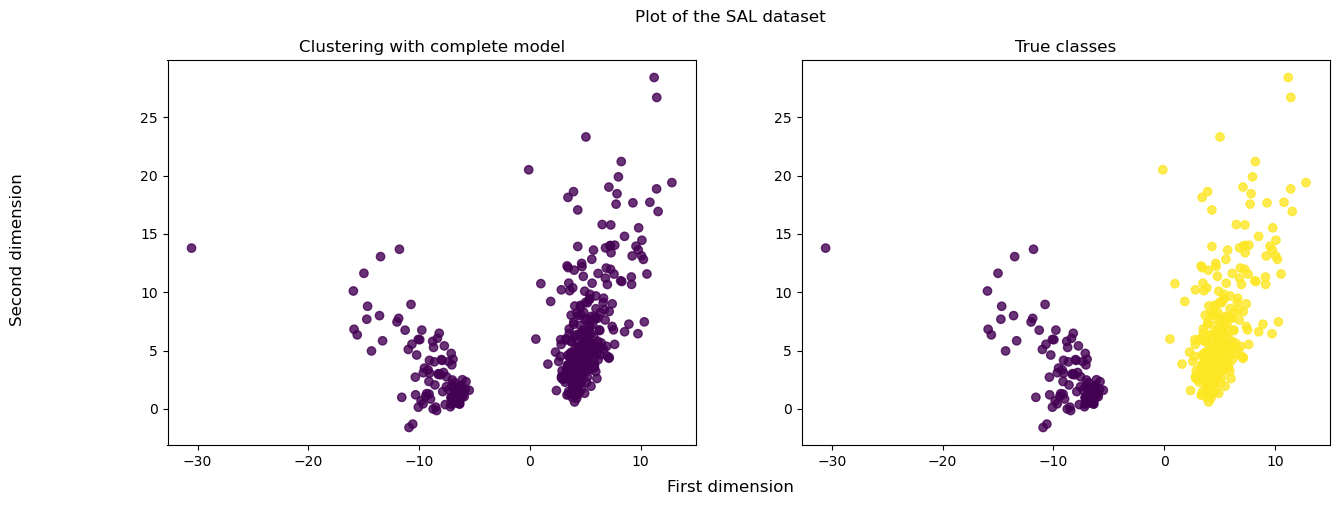

In [74]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].scatter(*full_data[:,:2].T,c=labels_sal_3,alpha=0.8)
axes[0].set_title('Clustering with complete model')
axes[1].scatter(*full_data[:,:2].T,c=true_labels_sal,alpha=0.8)
axes[1].set_title('True classes')
plt.suptitle('Plot of the SAL dataset')
fig.supxlabel('First dimension')
fig.supylabel('Second dimension')
plt.show()

### The `history` attribute

Any instantiation from `GaussianDEMMD`, `StudentDEMMD` or `SALDEMMD` classes contains an attribute named `history`. This attribute is an instance of `Historic` class which allows to save through the estimation process the different estimated model parameters.

The `get_params` method returns the different attributes of `history` in a dictionnary. We can then observe evolution of estimates and parameters over iterations.

In [75]:
dict_history = GDEM1.history.get_params()

In [76]:
dict_history.keys()

dict_keys(['_abc_impl', 'beta', 'covariances', 'final_labels', 'labels', 'log_likelihood', 'means', 'n_components', 'p_discrete', 'proportions'])

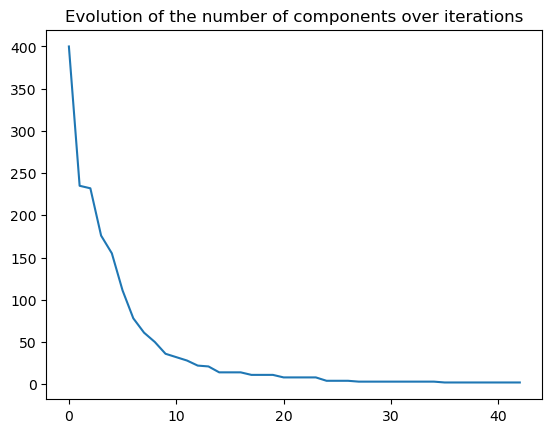

In [77]:
plt.title('Evolution of the number of components over iterations')
plt.plot(dict_history['n_components'])
plt.show()

A more complete dictionnary including the DEM-MD class attributes can be obtain with the `export_history` method from a DEM-MD class.\
Args of `export_history` method are: boolean `save_file`, `path` and `name` to export in a file named `name` the resulting dictionnary. Example below.

In [78]:
dict_complete_history = GDEM1.export_history()

In [79]:
dict_complete_history.keys()

dict_keys(['proportions', 'means', 'covariances', 'beta', 'n_components', 'p_discrete', 'log_likelihood', 'labels', 'final_labels', 'converged_', 'n_iter', 'warm_start', 'init_params', 'maxiter'])

## Estimation errors <a  id="fourth-part"></a>

We present here some pieces of codes provided to compare errors on estimated and true parameters.\
However the user is free to use other ways to analyze, as several limits may be limiting here.\
Keep in mind that:
- only models with the correct number of components (K) can be compared to the true models.
- when computing permutation between classes, we assume that locations (centers, means) have enough information to find the perfect permutation. (Should be improve in the futur)

We give here code example for the three Gaussian models. This is the same process to obtain errors on the Student or SAL models.

Firtly, we compute a permutation vector to correctly link corresponding classes in the true and estimated models.

In [80]:
from utils.calculation import *
permutation_gaussian1 = compute_min_permut(GDEM1.means,dict_cont_gaussian['locations'])
permutation_gaussian2 = compute_min_permut(GDEM2.means,dict_cont_gaussian['locations'])
permutation_gaussian3 = compute_min_permut(GDEM3.means,dict_cont_gaussian['locations'])

### Errors on estimation of the 1st mixture model

Secondly, we can swap labels to obtain matching classes. From the true and estimated labels the user can compute a confusion matrix for example.

In [81]:
labels_gaussian_1_permut = swap_labels(GDEM1.means,labels_gaussian_1,dict_cont_gaussian,permutation_gaussian1)

Thirdly, we compute and print relatives errors on the different parameters for the first Gaussian mixture model here. Remember that in the first model we only considered the continuously distributed features.

In [82]:
print(f"Relative errors on proportions")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_proportions(GDEM1.proportions,dict_cont_gaussian['proportions'],permutation_gaussian1)[j],3)}%")
    
print(f"\nRelative errors on locations")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_locations(GDEM1.means,dict_cont_gaussian['locations'],permutation_gaussian1)[j],3)}%")
    
print(f"\nRelative errors on scale matrices")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_scales(GDEM1.covariances,dict_cont_gaussian['scales'],permutation_gaussian1)[j],3)}%")

Relative errors on proportions
Cluster 1: 48.842%
Cluster 2: 16.281%

Relative errors on locations
Cluster 1: 3.702%
Cluster 2: 0.892%

Relative errors on scale matrices
Cluster 1: 6.016%
Cluster 2: 6.22%


### Errors on estimation of the 2nd mixture model

Same process than with the first model.\
The different here is the additional feature, following a Multinomial distribution, and we can compute its error.

In [83]:
labels_gaussian_2_permut = swap_labels(GDEM2.means,labels_gaussian_2,dict_cont_gaussian,permutation_gaussian2)

In [84]:
print(f"Relative errors on proportions")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_proportions(GDEM2.proportions,dict_cont_gaussian['proportions'],permutation_gaussian2)[j],3)}%")
    
print(f"\nRelative errors on locations")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_locations(GDEM2.means,dict_cont_gaussian['locations'],permutation_gaussian2)[j],3)}%")
    
print(f"\nRelative errors on scale matrices")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_scales(GDEM2.covariances,dict_cont_gaussian['scales'],permutation_gaussian2)[j],3)}%")

print(f"\nRelative errors on multinomial parameters")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_multi(GDEM2.p_discrete[0],dict_discr_gaussian['Multinomial0'],permutation_gaussian2)[j],3)}%")

Relative errors on proportions
Cluster 1: 48.842%
Cluster 2: 16.281%

Relative errors on locations
Cluster 1: 3.702%
Cluster 2: 0.892%

Relative errors on scale matrices
Cluster 1: 6.016%
Cluster 2: 6.22%

Relative errors on multinomial parameters
Cluster 1: 4.0%
Cluster 2: 6.667%


### Errors on estimation of the 3rd mixture model

Same process on the third model, so with the complete dataset.

In [85]:
labels_gaussian_3_permut = swap_labels(GDEM3.means,labels_gaussian_3,dict_cont_gaussian,permutation_gaussian3)

In [86]:
print(f"Relative errors on proportions")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_proportions(GDEM3.proportions,dict_cont_gaussian['proportions'],permutation_gaussian3)[j],3)}%")
    
print(f"\nRelative errors on locations")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_locations(GDEM3.means,dict_cont_gaussian['locations'],permutation_gaussian3)[j],3)}%")
    
print(f"\nRelative errors on scale matrices")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_scales(GDEM3.covariances,dict_cont_gaussian['scales'],permutation_gaussian3)[j],3)}%")
    
    
print(f"\nRelative errors on multinomial parameters")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_multi(GDEM3.p_discrete[0],dict_discr_gaussian['Multinomial0'],permutation_gaussian3)[j],3)}%")
    
print(f"\nRelative errors on poisson parameters")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_poisson(GDEM3.p_discrete[1].flatten(),dict_discr_gaussian['Poisson1'],permutation_gaussian3)[j],3)}%")
    
print(f"\nRelative errors on bernoulli parameters")
for j in range(len(dict_cont_gaussian['proportions'])):
    print(f"Cluster {j+1}: "+f"{round(100*errors_bernoulli(GDEM3.p_discrete[2].flatten(),dict_discr_gaussian['Bernoulli2'],permutation_gaussian3)[j],3)}%")

Relative errors on proportions
Cluster 1: 48.846%
Cluster 2: 16.282%

Relative errors on locations
Cluster 1: 3.702%
Cluster 2: 0.892%

Relative errors on scale matrices
Cluster 1: 6.016%
Cluster 2: 6.22%

Relative errors on multinomial parameters
Cluster 1: 4.0%
Cluster 2: 6.667%

Relative errors on poisson parameters
Cluster 1: 0.267%
Cluster 2: 0.55%

Relative errors on bernoulli parameters
Cluster 1: 10.0%
Cluster 2: 2.857%
